# Обзор собранных данных и проверка их на адекватность

В этом блоке я хотел бы убедиться, что мое решение с 1 этапа на счет ``all:video AND all:generation`` не дало слишком много шума.
Также хотел бы проверить представленность статей по всему временному промежутку за 2024 год.

Загрузим данные, которые мы получили из ``1_get_papers.ipynb``

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

df_2024 = pd.read_csv('data/video_generation_2024.csv')

df_2024.sample(3, random_state=1)

,entry_id,arxiv_id,title,authors,abstract,published,updated,year,categories,primary_category,pdf_url,arxiv_url,doi,comment,journal_ref
6739,http://arxiv.org/abs/2401.08559v2,2401.08559v2,Multi-Track Timeline Control for Text-Driven 3...,"Mathis Petrovich, Or Litany, Umar Iqbal, Micha...",Recent advances in generative modeling have le...,2024-01-16,2024-05-24,2024,"cs.CV, cs.GR, cs.LG",cs.CV,http://arxiv.org/pdf/2401.08559v2,http://arxiv.org/abs/2401.08559v2,NaN,"CVPR 2024, HuMoGen Workshop",NaN
1287,http://arxiv.org/abs/2411.03795v4,2411.03795v4,VQA$^2$: Visual Question Answering for Video Q...,"Ziheng Jia, Zicheng Zhang, Jiaying Qian, Haoni...",The advent and proliferation of large multi-mo...,2024-11-06,2024-12-02,2024,"cs.CV, cs.AI",cs.CV,http://arxiv.org/pdf/2411.03795v4,http://arxiv.org/abs/2411.03795v4,NaN,23 pages 12 figures,NaN
1819,http://arxiv.org/abs/2410.08926v3,2410.08926v3,Zero-Shot Pupil Segmentation with SAM 2: A Cas...,"Virmarie Maquiling, Sean Anthony Byrne, Dieder...",We explore the transformative potential of SAM...,2024-10-11,2025-01-13,2024,"cs.CV, cs.AI, cs.HC",cs.CV,http://arxiv.org/pdf/2410.08926v3,http://arxiv.org/abs/2410.08926v3,NaN,Virmarie Maquiling and Sean Anthony Byrne cont...,NaN


## Динамика появление публикаций на тему видеогенрации

В первую очередь хочется посмотреть на динамику публикаций, чтобы была уверенность того, что есть данные за каждый месяц.

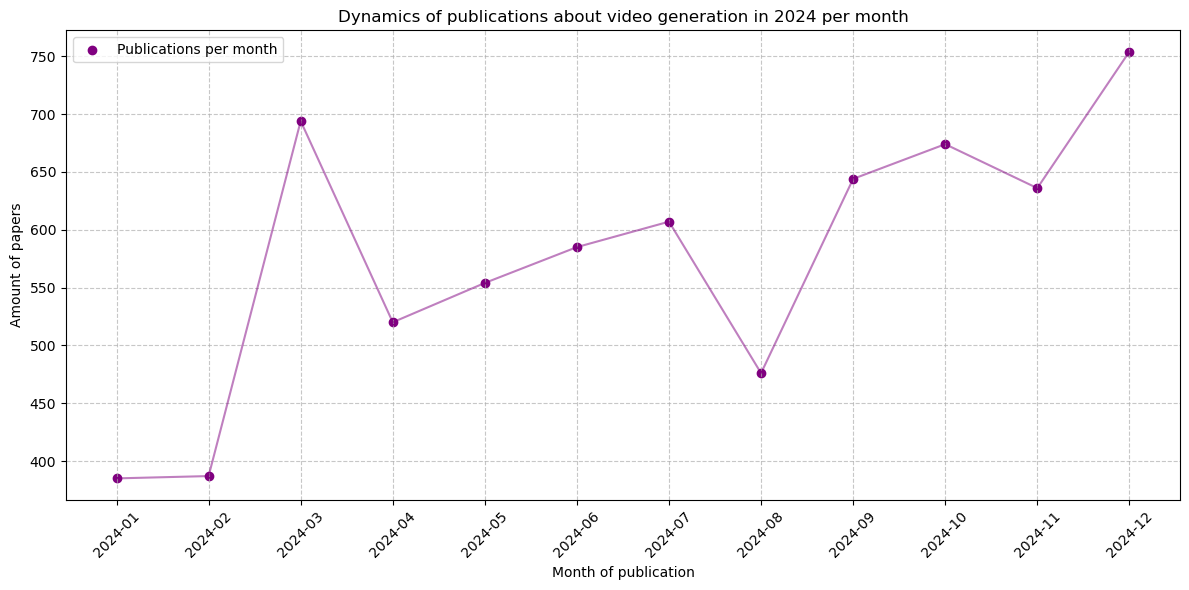

In [8]:
df_2024['published'] = pd.to_datetime(df_2024['published'])

df_2024['month'] = df_2024['published'].dt.to_period('M')

monthly_counts = df_2024.groupby('month').size().reset_index(name='count')

monthly_counts['month'] = monthly_counts['month'].astype(str)

plt.figure(figsize=(12, 6))
plt.scatter(monthly_counts['month'], monthly_counts['count'], color='purple', label='Publications per month')
plt.plot(monthly_counts['month'], monthly_counts['count'], color='purple', linestyle='-', alpha=0.5)

plt.xlabel('Month of publication')
plt.ylabel('Amount of papers')
plt.title('Dynamics of publications about video generation in 2024 per month')
plt.xticks(rotation=45)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend()
plt.tight_layout()
plt.show()


Отлично, за каждый месяц у нас есть более 400 статей, также уже можно увидеть некоторый положительный тренд на появление статей по видеогенрации, но каких-то серьезных выводов я бы не делал, поскольку данные могут быть зашумлеными.

# Распредление публикаций по категориям 

У arxiv, у каждой статьи есть метка ``primary_category``, которая отвечает за то какой категории принадлежит статья.

Подробнее с интерпритацией меток можно ознакомиться с помощью официального сайта [arxiv](https://arxiv.org/category_taxonomy)

Давайте теперь посмотрим на категории публикакций   

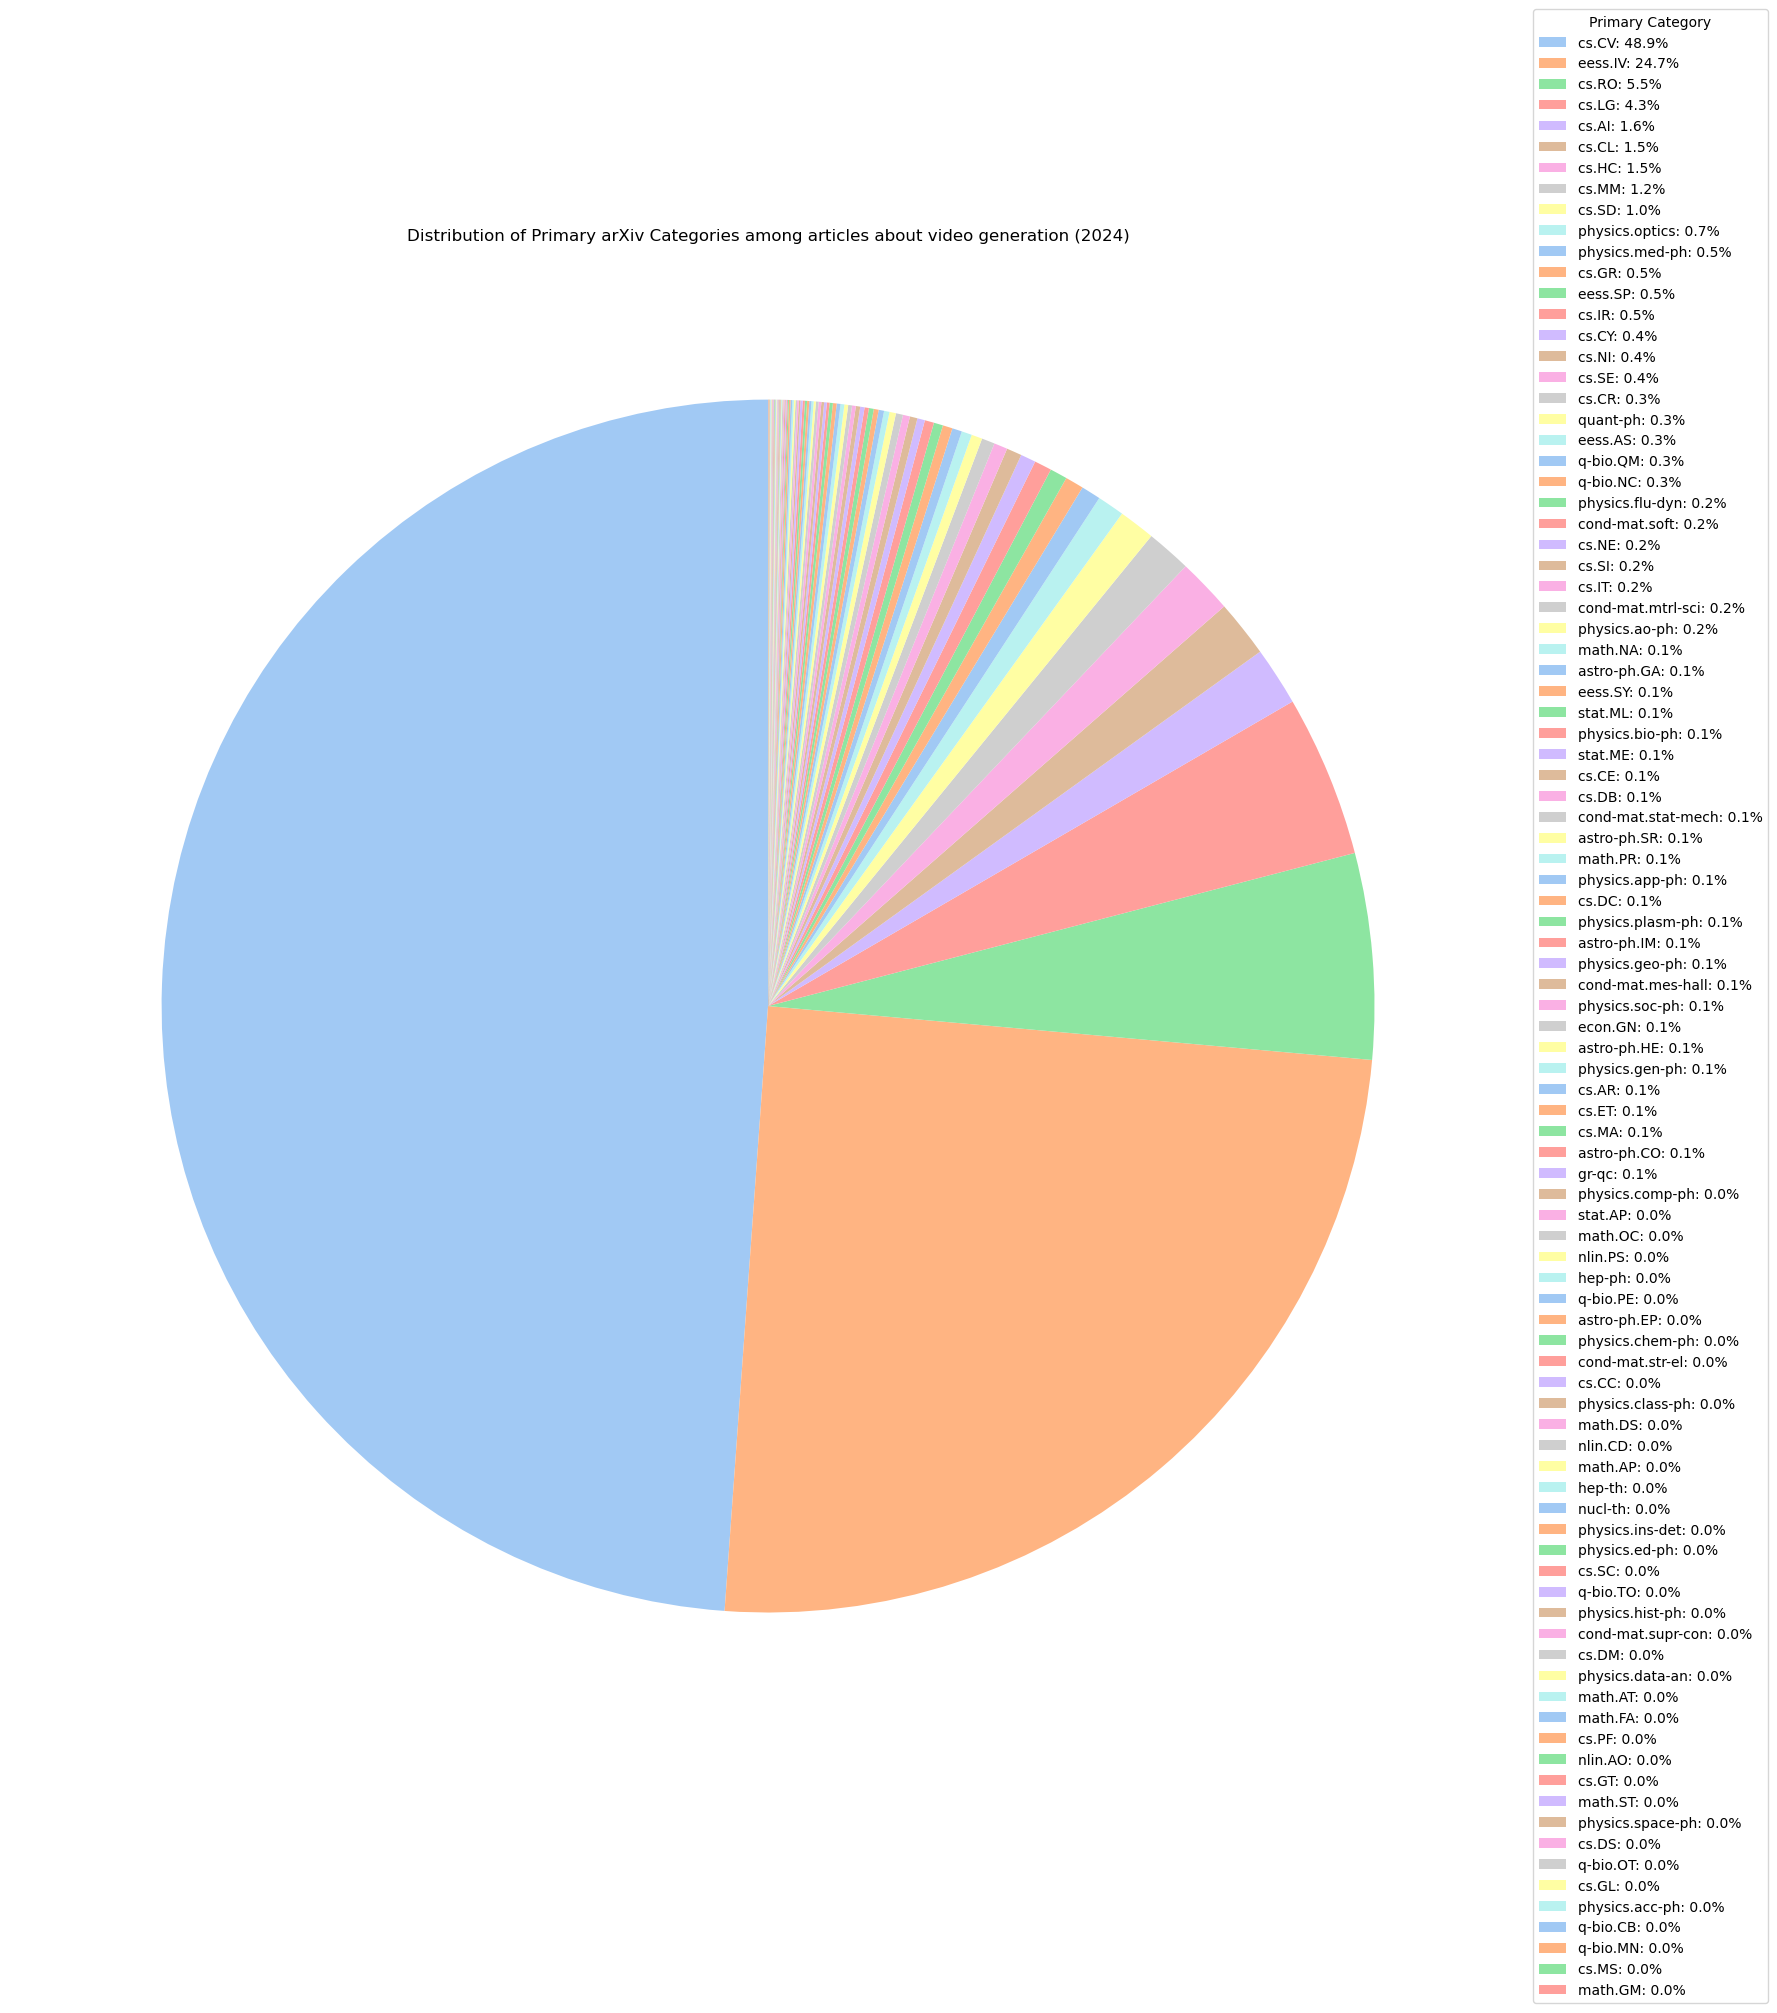

In [3]:
category_counts = df_2024['primary_category'].value_counts(normalize=True)

fig, ax = plt.subplots(figsize=(20, 20))
wedges, texts = ax.pie(
    category_counts,
    startangle=90,
    colors=sns.color_palette("pastel"),
)

labels = [f"{cat}: {pct:.1%}" for cat, pct in category_counts.items()]
ax.legend(wedges, labels, title="Primary Category", loc="center left", bbox_to_anchor=(1, 0.5))

plt.title("Distribution of Primary arXiv Categories among articles about video generation (2024)")
plt.tight_layout()
plt.show()

Как можно увидеть из пайчарта топ 2 категории это cs.CV (Computer Vision and Pattern Recognition) и eess.IV (Image and Video Processing), поэтому подход к сбору данных, можно считать адекватным, также стоит отметить, что у нас есть большое количество аутлайеров в виде маленьких категорий, поэтому использование HDBSCAN оправдно, стоит также посмотреть потом на подозрительные кластеры и соотнести их с ``primary_categories``.

Давайте перейдем к построению модели тематического моделирования и перейдем к ноутбуку ``3_topic_modeling.ipynb``

*Для отчета  сделаем график с меньшей легендой

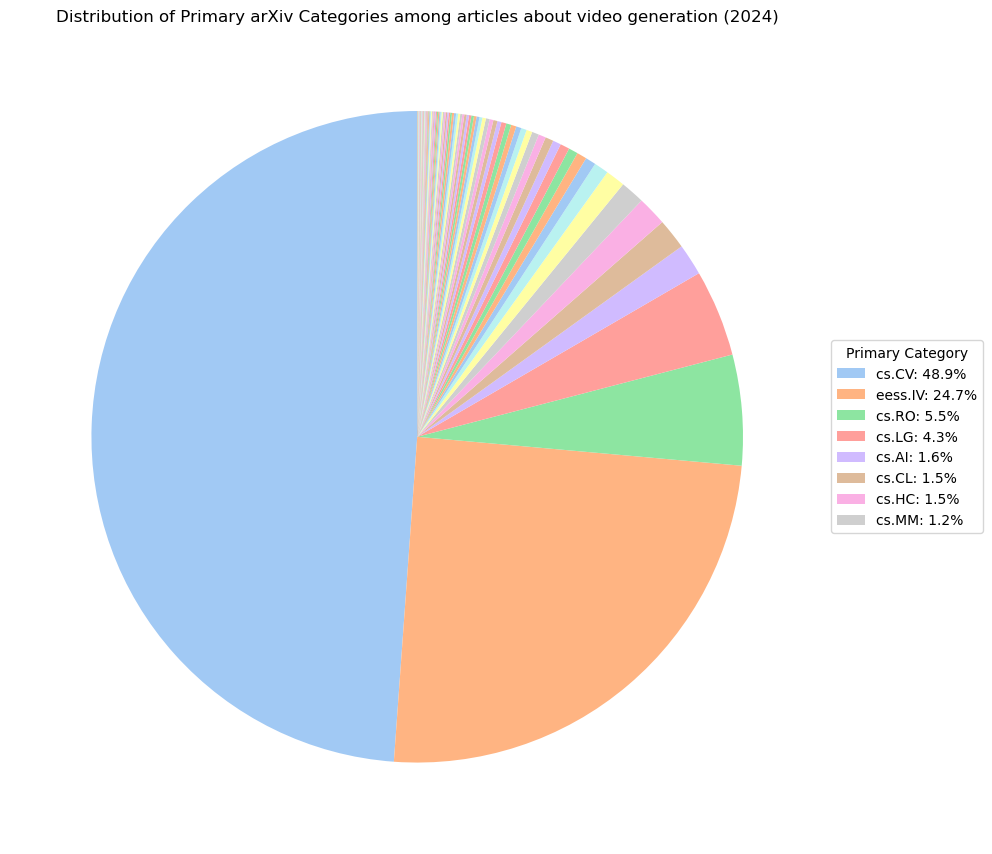

In [7]:
category_counts = df_2024['primary_category'].value_counts(normalize=True)

fig, ax = plt.subplots(figsize=(10, 10))
wedges, texts = ax.pie(
    category_counts,
    startangle=90,
    colors=sns.color_palette("pastel"),
)


legend_labels = [f"{cat}: {pct:.1%}" for cat, pct in category_counts.items() if pct >= 0.01]
legend_wedges = [wedge for wedge, (cat, pct) in zip(wedges, category_counts.items()) if pct >= 0.01]

ax.legend(legend_wedges, legend_labels, title="Primary Category", loc="center left", bbox_to_anchor=(1, 0.5))

plt.title("Distribution of Primary arXiv Categories among articles about video generation (2024)")
plt.tight_layout()
plt.show()
